# ---------------------------------------------------------------------------------------------------------------
#
#         R Script to Download and Graph SNOTEl (Snow) data from the Upper Columbia
#            Author: Ryan Niemeyer, Watershed Program Manager at the Upper Columbia Salmon Recovery Board
#            Date: Fall 2020
#
# ---------------------------------------------------------------------------------------------------------------



In [2]:
# ------------------ Year to Plot ------------------
year_to_plot = 2019
# --------------- Pathway to Output Figure --------------
path_output = 'Y:/Ryan/Misc/Annual_Report/2019/snotel_graph2.pdf'

# -------------------------------------------------------------------------------------
#         Install Libraries
# -------------------------------------------------------------------------------------

In [3]:
library('snotelr')
library('repr')

Warning message:
"package 'snotelr' was built under R version 4.0.3"
Warning message:
"package 'repr' was built under R version 4.0.3"


# -------------------------------------------------------------------------------------
#         Generate Function to Read in and Process data
# -------------------------------------------------------------------------------------

In [4]:
snotel_read_and_process_function = function(site_x, years_x){
    

    # -------------------- download SNOTEL data -----------------------
    data_x <- snotel_download(site_id = c(site_x), internal = TRUE)

    # --------------- export name -------------------
    print("  DOWNLOADED: ")
    print(data_x$site_name[1])
    
    # ------------------ remove superfluous data ---------------
    data_x = data_x[,c('date','snow_water_equivalent','precipitation_cumulative','temperature_max','temperature_min','temperature_mean','precipitation')]    # ----------------
    
    # ------------------ rename with units ---------------
    colnames(data_x) = c('date','snow_water_equivalent_cm','precipitation_cumulative_mm','temperature_max_degC','temperature_min_degC','temperature_mean_degC','precipitation_mm')    # ----------------
    
    # ---------------------convert SWE from centimeters to inches -------
    data_x$snow_water_equivalent_inches = data_x$snow_water_equivalent_cm * 0.3937008
    
    # ---------------------convert precip from mm to inches -------
    data_x$precipitation_cumulative_inches = data_x$precipitation_cumulative_mm * 0.03937008
    data_x$precipitation_inches = data_x$precipitation_mm * 0.03937008
    
    # ---------------------convert temperature from degres Celsius to degres Fahrenheit -------
    data_x$temperature_max_degF = (data_x$temperature_max_degC * 1.8) + 32
    data_x$temperature_min_degF = (data_x$temperature_min_degC * 1.8) + 32
    data_x$temperature_mean_degF = (data_x$temperature_mean_degC * 1.8) + 32
    
    # -------------------------- convert data to datetime class ---------
    data_x$datetime = as.POSIXct(data_x$date, format="%Y-%m-%d",tz="America/Los_Angeles")
    
    # -------------------------- subset only years you want ---------
    years_data_x = format(data_x$datetime, format="%Y")
    data_x = data_x[which( years_data_x >= min(years_x)  &  years_data_x <= max(years_x)  ), ]
    
    # ---------------------- output data ------------
    return(data_x)
    
}

In [5]:
snotel_generate_median_snow_function = function(metric_vector, date_vector, year_for_days){
    
    # --------------------- get day of year ---------------
    day_of_year =  format(date_vector, format="%j")
    
    # ----------------------- get median for that day of year -------------
    data_x = as.data.frame(cbind(day_of_year, metric_vector))
    data_x$metric_vector = as.numeric(data_x$metric_vector)
    median_x = aggregate(data_x$metric_vector, list(data_x$day_of_year), FUN=median, na.rm=TRUE, na.action = NULL)
    colnames(median_x) = c('day_of_year', 'metric')
    
    # -------------------- remove day 366 (from leap year) ------------
    median_x = median_x[1:365,]
    
    # ------------- add day of hydrologic year --------------
    median_x$day_of_hydro_year = median_x$day_of_year
    
    # ---------- days after Oct. 1 -------------
    days_previous_calendar_year = which(median_x$day_of_year > 274)
    median_x$day_of_hydro_year[days_previous_calendar_year] = paste(median_x$day_of_hydro_year[days_previous_calendar_year],
                                                                    year_for_days - 1, sep="-")
    
    # ---------- days before Oct. 1 -------------
    days_during_calendar_year = which(median_x$day_of_year <= 274)
    median_x$day_of_hydro_year[days_during_calendar_year] = paste(median_x$day_of_hydro_year[days_during_calendar_year],
                                                                    year_for_days, sep="-")
    # --------------- get date time -------------
    median_x$day_of_hydro_year =  as.POSIXct(median_x$day_of_hydro_year, format="%j-%Y",tz="America/Los_Angeles")
    
    # ----------------- return the data ------------------
    return(median_x)
    
}

In [6]:
# ---------------- water year function ----------
wtr_yr <- function(dates, start_month=10) {
  # Convert dates into POSIXlt
  dates.posix = as.POSIXlt(dates)
  # Year offset
  offset = ifelse(dates.posix$mon >= start_month - 1, 1, 0)
  # Water year
  adj.year = dates.posix$year + 1900 + offset
  # Return the water year
  adj.year
}

# -------------------------------------------------------------------------------------
#         Read in all the SNOTEL data, get the median snow
# -------------------------------------------------------------------------------------

In [7]:
# ---------------------- upload the metadata sites -------------
site_path_x = "P:/GIS/Water/Snow/Okanogan_Chelan_Kittitas_SNOTEL_sites_metadata.csv"
Upper_Columbia_site_list = read.csv(site_path_x, header=T)

# ------------- remove sites you don't want to read in ---------
remove_sites = c(1171,1159, 1259)  # NOTE - these sites weren't downloading
for(site_x in remove_sites){
    x = which(Upper_Columbia_site_list$site_number == site_x)
    Upper_Columbia_site_list = Upper_Columbia_site_list[-x,]
}


# --------------- sites to plot ----------------
sites_to_plot = cbind(c(728, 644, 711, 515, 699,791,841),
                     c('Salmon Meadows, elev=4460 ft','Moses Mountain, elev=5010 ft',
                      'Rainy Pass, elev=4890 ft','Harts Pass, elev=6490 ft',
                      'Pope Ridge, elev=3590 ft',
                       'Stevens Pass, elev=3950 ft','Upper Wheeler, elev=4330 ft'))
sites_to_plot = as.data.frame(sites_to_plot)
colnames(sites_to_plot) = c('site_number','site_name')
sites_to_plot$site_name_simple = c('Salmon Meadows','Moses Mountain',
                      'Rainy Pass','Harts Pass',
                      'Pope Ridge',
                       'Stevens Pass','Upper Wheeler')

# ----------- original version -----
sites_to_plot_B = cbind(c(728, 644, 711, 515, 699,791,841),
                     c('Salmon Meadows, elev=4460 ft (Okanogan)','Moses Mountain, elev=5010 ft (Okanogan)',
                      'Rainy Pass, elev=4890 ft (Methow)','Harts Pass, elev=6490 ft (Methow)',
                      'Pope Ridge, elev=3590 ft (Entiat)',
                       'Stevens Pass, elev=3950 ft (Wenatchee)','Upper Wheeler, elev=4330 ft (Wenatchee)'))

In [8]:
sites_to_plot

site_number,site_name,site_name_simple
<chr>,<chr>,<chr>
728,"Salmon Meadows, elev=4460 ft",Salmon Meadows
644,"Moses Mountain, elev=5010 ft",Moses Mountain
711,"Rainy Pass, elev=4890 ft",Rainy Pass
515,"Harts Pass, elev=6490 ft",Harts Pass
699,"Pope Ridge, elev=3590 ft",Pope Ridge
791,"Stevens Pass, elev=3950 ft",Stevens Pass
841,"Upper Wheeler, elev=4330 ft",Upper Wheeler


In [9]:
sites_to_plot

site_number,site_name,site_name_simple
<chr>,<chr>,<chr>
728,"Salmon Meadows, elev=4460 ft",Salmon Meadows
644,"Moses Mountain, elev=5010 ft",Moses Mountain
711,"Rainy Pass, elev=4890 ft",Rainy Pass
515,"Harts Pass, elev=6490 ft",Harts Pass
699,"Pope Ridge, elev=3590 ft",Pope Ridge
791,"Stevens Pass, elev=3950 ft",Stevens Pass
841,"Upper Wheeler, elev=4330 ft",Upper Wheeler


# ------------------------ loop to read in all the data -----------------

In [10]:
all_snotel_data = list() # creates a list

for(site_x in Upper_Columbia_site_list$site_number){
    
    # ---------------- read in data and add to master list (all_snotel_data) --------
    print('starting download of....')
    print(site_x)
    all_snotel_data[[site_x]] = snotel_read_and_process_function(site_x, seq(1979,2019))
    print("         DONE                 ")
    print("       ")
}




[1] "starting download of...."
[1] 352


[1] "  DOWNLOADED: "
[1] "blewett pass "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 606


[1] "  DOWNLOADED: "
[1] "lyman lake "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 681


[1] "  DOWNLOADED: "
[1] "park creek ridge "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 699


[1] "  DOWNLOADED: "
[1] "pope ridge "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 711


[1] "  DOWNLOADED: "
[1] "rainy pass "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 841


[1] "  DOWNLOADED: "
[1] "upper wheeler "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 478


[1] "  DOWNLOADED: "
[1] "fish lake "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 507


[1] "  DOWNLOADED: "
[1] "grouse camp "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 734


[1] "  DOWNLOADED: "
[1] "sasse ridge "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 832


[1] "  DOWNLOADED: "
[1] "trough "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 515


[1] "  DOWNLOADED: "
[1] "harts pass "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 644


[1] "  DOWNLOADED: "
[1] "moses mtn "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 728


[1] "  DOWNLOADED: "
[1] "salmon meadows "
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 791


[1] "  DOWNLOADED: "
[1] "stevens pass "
[1] "         DONE                 "
[1] "       "


# -------------------------------------------------------------------------------------
#        Calculate SNOW Statistics
# -------------------------------------------------------------------------------------

## ---------------------------------------------------------------------------
##     Functions
## ---------------------------------------------------------------------------

In [11]:
melt_out_day_function = function(annual_snow, calendar_day_after, year_x){
    
    # ----------- get all snow after day ----------
    annual_snow_sub = annual_snow[calendar_day_after:365]
    
    # ----------- find first day snow was 0 -----------
    first_day = min(which(annual_snow_sub == 0)) 
    first_day = first_day + calendar_day_after - 92 # get calendar year day
    first_day = paste(first_day,year_x, sep="-")
    first_day = as.Date(first_day, format='%j-%Y')
    first_day_calendar_day = format(first_day, '%j') # output calendar day
    first_day_short = format(first_day, "%d-%b") # output as day and month
    
    # ------------- return ---------------
    return(c(year_x, first_day_calendar_day, first_day_short))
    
}

In [12]:
SNOTEL_statistics_function = function(metric_data, date_data, year_to_plot){
    
    # ----------- water year -----------
    date_data_wtr_yr = wtr_yr(date_data)
    
    # ---------------------------------------------------------------------------------
    #        Annual peak snowpack statistics          
    # ---------------------------------------------------------------------------------

    # ----------------- calculate annual peak snow statistics -----------------
    annual_max = aggregate(metric_data, list(date_data_wtr_yr), max)
    annual_max_year = round( annual_max[which(annual_max[ ,1] == year_to_plot),2], 2)
    mean_annual_max = mean(annual_max[,2], na.rm=T)
    prcnt_annual_max_year = round((annual_max_year/mean_annual_max) * 100, 2)
    delta_annual_max_year = round((annual_max_year - mean_annual_max), 2)
    
    # -------------- day of annual peak snow ---------------
    day_of_annual_snow = c()
    unique_years = unique(date_data_wtr_yr)
    for(i in 1:length(unique_years)){

        # ----------------- get snow this year -----------------
        year_x = unique_years[i]
        x = which(date_data_wtr_yr == unique_years[i])
        # ----- get data for that year -----
        annual_snow = metric_data[x]
        # -------------- calculate calendar day of peak -----------
        day_of_peak = which(annual_snow == annual_max[i,2])
        day_of_peak = day_of_peak[1] - 92 # get calendary year day, from water year day
        # ------------------ calculate month and day ---------
        day_of_peak_2 = paste(day_of_peak,  year_x, sep="-")
        day_of_peak_2 = as.Date(day_of_peak_2, format='%j-%Y')
        day_of_peak_2 = format(day_of_peak_2, "%d-%b") # output as day and month
        # ------------- output data --------
        output_row = c(unique_years[i], day_of_peak[1], day_of_peak_2[1])
        day_of_annual_snow = rbind(day_of_annual_snow, output_row)
    }
    
    # ------------------------- calculate for this year -----------
    peak_snow_year_day = as.numeric(day_of_annual_snow[which(day_of_annual_snow[ ,1] == year_to_plot),2])
    mean_peak_snow_ALL = round(  ( mean(as.numeric(day_of_annual_snow[,2]), na.rm=T) ), 2)
    delta_peak_snow_day = round(peak_snow_year_day - mean_peak_snow_ALL, 2) # days difference from average
    
    
    # ---------------------------------------------------------------------------------
    #           Annual melt out statistics
    # ---------------------------------------------------------------------------------

    # ----------------- calculate annual melt out day statistics -----------------
    unique_years = unique(date_data_wtr_yr)
    melt_out_data_frame = c()
    for(i in 1:length(unique_years)){
        
        # ----------------- get snow this year -----------------
        x = which(date_data_wtr_yr == unique_years[i])
        annual_snow = metric_data[x]
        
        # ------------- calculate melt out year ----------------
        melt_data_x = melt_out_day_function(annual_snow, 105, unique_years[i])
        melt_out_data_frame = rbind(melt_out_data_frame, melt_data_x)
    }
    
    # ------------------------- calculate for this year -----------
    melt_out_day = as.numeric(melt_out_data_frame[which(melt_out_data_frame[ ,1] == year_to_plot),2])
    mean_melt_out_ALL = round( (mean(as.numeric(melt_out_data_frame[,2]), na.rm=T)),  2)
    delta_melt_out_day = round(melt_out_day - mean_melt_out_ALL, 2) # days difference from average
    
    
    # ---------------------------------------------------------------------------------
    #      Output         
    # ---------------------------------------------------------------------------------
    output_x = t(as.data.frame(c(annual_max_year, delta_annual_max_year, prcnt_annual_max_year,
                peak_snow_year_day, delta_peak_snow_day,
                 melt_out_day, delta_melt_out_day
                )))
    rownames(output_x) = 1
    colnames(output_x) = c('peak_SWE_this_year','peak_SWE_DELTA_change_inches', 'peak_SWE_PRCNT','peak_SWE_this_year_DAY','peak_SWE_this_year_DAYS_from_mean',
                        'snow_disappearance_day_this_year','snow_disappearance_DAY_from_mean')
    
    #print(output_x)
    return(output_x)
    
}

In [ ]:
sites_to_plot

## ---------------------------------------------------------------------------
##     Calculate Snow Statistics
## ---------------------------------------------------------------------------

In [13]:
# ------------ data frame for statistics ---------
snow_statistics_output = c()

for(i in 1:nrow(sites_to_plot)){

    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(sites_to_plot$site_number[i])
    # ------------------------ generate the median snotel -------------------
    snow_data_x = as.numeric(as.character(all_snotel_data[[as.numeric(sites_to_plot$site_number[i])]]$'snow_water_equivalent_inches' ))
    date_vector = all_snotel_data[[as.numeric(sites_to_plot$site_number[i])]]$'datetime'
    
    # ---------------- generate output data --------------
    output_data_x = SNOTEL_statistics_function(snow_data_x, date_vector, year_to_plot)
    sites_df = t(as.data.frame(c(sites_to_plot$site_name_simple[i], sites_to_plot$site_number[i])))
    colnames(sites_df) = c("site_name", "site_number")
    output_data_x = cbind(sites_df, output_data_x)
    rownames(output_data_x) = i
    snow_statistics_output = rbind(snow_statistics_output, output_data_x)
    
}
snow_statistics_output = as.data.frame(snow_statistics_output)
snow_statistics_output$peak_SWE_this_year = as.numeric(snow_statistics_output$peak_SWE_this_year)
snow_statistics_output$peak_SWE_PRCNT = as.numeric(snow_statistics_output$peak_SWE_PRCNT)
snow_statistics_output$peak_SWE_this_year_DAY = as.numeric(snow_statistics_output$peak_SWE_this_year_DAY)
snow_statistics_output$peak_SWE_this_year_DAYS_from_mean = as.numeric(snow_statistics_output$peak_SWE_this_year_DAYS_from_mean)
snow_statistics_output$snow_disappearance_day_this_year = as.numeric(snow_statistics_output$snow_disappearance_day_this_year)
snow_statistics_output$snow_disappearance_DAY_from_mean = as.numeric(snow_statistics_output$snow_disappearance_DAY_from_mean)
snow_statistics_output$peak_SWE_DELTA_change_inches = as.numeric(snow_statistics_output$peak_SWE_DELTA_change_inches)


[1] 1
[1] "728"


Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"
Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"
Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"


[1] 2
[1] "644"


Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"


[1] 3
[1] "711"


Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"
Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"
Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"


[1] 4
[1] "515"


Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"
Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"
Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"


[1] 5
[1] "699"


Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"


[1] 6
[1] "791"


Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"


[1] 7
[1] "841"


Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"
Warning message in min(which(annual_snow_sub == 0)):
"no non-missing arguments to min; returning Inf"


In [122]:
snow_statistics_output

,site_name,site_number,peak_SWE_this_year,peak_SWE_DELTA_change_inches,peak_SWE_PRCNT,peak_SWE_this_year_DAY,peak_SWE_this_year_DAYS_from_mean,snow_disappearance_day_this_year,snow_disappearance_DAY_from_mean
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Salmon Meadows,728,74.02,-33.42,68.89,74,-8.58,110,-12.19
2,Moses Mountain,644,116.93,-41.92,73.61,107,14.52,131,-7.18
3,Rainy Pass,711,253.94,-149.20,62.99,109,5.97,154,-18.16
4,Harts Pass,515,394.09,-77.24,83.61,110,-1.47,161,-13.92
5,Pope Ridge,699,155.12,-22.45,87.36,77,6.00,117,-11.66
6,Stevens Pass,791,296.06,-91.09,76.47,74,-12.08,137,-18.59
7,Upper Wheeler,841,127.95,-0.24,99.81,71,-11.37,131,-0.71


### ----------------------------------------------------------
###           statistics for peak SWE 
### ----------------------------------------------------------

In [1]:
print('-----Maximum -----:')
max(snow_statistics_output$peak_SWE_this_year)
print('-----Mean -----:')
round( mean(snow_statistics_output$peak_SWE_this_year),  2)
print('-----Minimum -----:')
min(snow_statistics_output$peak_SWE_this_year)

[1] "-----Maximum -----:"


ERROR: Error in eval(expr, envir, enclos): object 'snow_statistics_output' not found


### ----------------------------------------------------------
###           statistics for DELTA of peak SWE (inches)
### ----------------------------------------------------------

In [123]:
print('-----Maximum -----:')
max(snow_statistics_output$peak_SWE_DELTA_change_inches)
print('-----Mean -----:')
round( mean(snow_statistics_output$peak_SWE_DELTA_change_inches), 2)
print('-----Minimum -----:')
min(snow_statistics_output$peak_SWE_DELTA_change_inches)

[1] "-----Maximum -----:"


[1] -0.24

[1] "-----Mean -----:"


[1] -59.37

[1] "-----Minimum -----:"


[1] -149.2

### ----------------------------------------------------------
###           statistics for peak SWE PERCENT change this year
### ----------------------------------------------------------

In [125]:
print('-----Maximum -----:')
max(snow_statistics_output$peak_SWE_PRCNT)
print('-----Mean -----:')
round( mean(snow_statistics_output$peak_SWE_PRCNT), 2)
print('-----Minimum -----:')
min(snow_statistics_output$peak_SWE_PRCNT)

[1] "-----Maximum -----:"


[1] 99.81

[1] "-----Mean -----:"


[1] 78.96

[1] "-----Minimum -----:"


[1] 62.99

### ----------------------------------------------------------
###           statistics for peak SWE day  (calendar day)
### ----------------------------------------------------------

In [126]:
print('-----Maximum -----:')
max(snow_statistics_output$peak_SWE_this_year_DAY)
print('-----Mean -----:')
round( mean(snow_statistics_output$peak_SWE_this_year_DAY), 1)
print('-----Minimum -----:')
min(snow_statistics_output$peak_SWE_this_year_DAY)

[1] "-----Maximum -----:"


[1] 110

[1] "-----Mean -----:"


[1] 88.9

[1] "-----Minimum -----:"


[1] 71

### ----------------------------------------------------------
###           statistics for peak SWE day DELTA day from mean
### ----------------------------------------------------------

In [127]:
print('-----Maximum -----:')
max(snow_statistics_output$peak_SWE_this_year_DAYS_from_mean)
print('-----Mean -----:')
round( mean(snow_statistics_output$peak_SWE_this_year_DAYS_from_mean), 1)
print('-----Minimum -----:')
min(snow_statistics_output$peak_SWE_this_year_DAYS_from_mean)

[1] "-----Maximum -----:"


[1] 14.52

[1] "-----Mean -----:"


[1] -1

[1] "-----Minimum -----:"


[1] -12.08

### ----------------------------------------------------------
###           statistics for snow disappearance day
### ----------------------------------------------------------

In [129]:
print('-----Maximum -----:')
max(snow_statistics_output$snow_disappearance_day_this_year)
print('-----Mean -----:')
round( mean(snow_statistics_output$snow_disappearance_day_this_year), 1)
print('-----Minimum -----:')
min(snow_statistics_output$snow_disappearance_day_this_year)

[1] "-----Maximum -----:"


[1] 161

[1] "-----Mean -----:"


[1] 134.4

[1] "-----Minimum -----:"


[1] 110

### ----------------------------------------------------------
###           statistics for snow disappearance day DELTA from mean
### ----------------------------------------------------------

In [130]:
print('-----Maximum -----:')
max(snow_statistics_output$snow_disappearance_DAY_from_mean)
print('-----Mean -----:')
round( mean(snow_statistics_output$snow_disappearance_DAY_from_mean),   1)
print('-----Minimum -----:')
min(snow_statistics_output$snow_disappearance_DAY_from_mean)

[1] "-----Maximum -----:"


[1] -0.71

[1] "-----Mean -----:"


[1] -11.8

[1] "-----Minimum -----:"


[1] -18.59

# ---------------------------------------------------------------------------
#     Calculate Precipitation and Temperature Statistics
# ---------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
#         Plot in panels
# -------------------------------------------------------------------------------------

In [114]:
155/188

[1] 0.8244681

In [ ]:
library('repr')

In [131]:



# options(repr.plot.width=2, repr.plot.height=4)

# Opening the graphical device
pdf(path_output, width = 7, height = 9)


par(mfrow=c(5, 2), oma=c(0.5, 0.8, 0, 0.8), mar=c(3.5, 5, 3, 0.5),  xpd=FALSE)

for(i in 1:nrow(sites_to_plot)){

    
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( i == 1){
        plot.new()
        par(xpd=TRUE)
        plot.new()
        legend("bottomright", inset=c(0,-0.2), legend=c("median snowpack", paste("snowpack in", year_to_plot, sep=" ") ), 
        lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5), seg.len = 5, cex=1.4)
        
    }
    par(xpd=FALSE)
    
    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(sites_to_plot$site_number[i])
    # ------------------------ generate the median snotel -------------------
    snow_data_x = as.numeric(as.character(all_snotel_data[[as.numeric(sites_to_plot$site_number[i])]]$'snow_water_equivalent_inches' ))
    date_vector = all_snotel_data[[as.numeric(sites_to_plot$site_number[i])]]$'datetime'
    
    # ------------------------ generate the median snotel -------------------
    median_snow_data_x = snotel_generate_median_snow_function(snow_data_x, date_vector, year_to_plot)
    
    # ------------------------------------------------------------
    #         Plot the Data
    # ------------------------------------------------------------
    max_ylim = max(median_snow_data_x$metric, na.rm=T) 
    max_ylim = max_ylim + max_ylim*0.2
    
    xlim_min = as.Date(paste('11-01-',year_to_plot-1, sep=""), format = '%m-%d-%Y')
    xlim_max = as.Date(paste('06-15-',year_to_plot, sep=""), format = '%m-%d-%Y')

    plot(median_snow_data_x$day_of_hydro_year, median_snow_data_x$metric, type='l', col='black', lwd=2,
        xlab=' ',ylab='snow water equivalent \n (inches)', ylim=c(0,max_ylim ), 
        xlim=c(min(median_snow_data_x$day_of_hydro_year) + 30*86400, max(median_snow_data_x$day_of_hydro_year) - 110*86400) )
    grid(lwd=1.5)
    lines(median_snow_data_x$day_of_hydro_year, median_snow_data_x$metric, col='black',lwd=2)
    
    mtext(sites_to_plot$site_name[i], side=3, line=0.3, font=2, cex=0.95)
    
    lines(date_vector, snow_data_x, lwd=2.5, col='blue', lty=2)

    # ------------------------------------------------------------
    #      Insert title
    # ------------------------------------------------------------
    
    if(i == 1){
        
        year_span = paste(year_to_plot-1,year_to_plot,sep=" - June ")
        mtext( paste("                          Snow Water Equivalent in Upper Columbia \n from Nov ",year_span, sep="") , side=3, line=9, cex=1.7, font=4)
        
    }
    
    # ------------------------------------------------------------
    #      Insert legend
    # ------------------------------------------------------------
    
    
    if(i ==2){
        
        #legend("topright", inset=c(0,-0.3), legend=c("median snowpack", paste("snowpack in", year_to_plot, sep=" ") ), 
        #       lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5))
        
    }
    
    # ------------------------------------------------------------
    #      Add Watershed Name
    # ------------------------------------------------------------
    
    if(i == 1){
        # mtext('                                                 Okanogan', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Okanogan - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 3){
        #mtext('                                                 Methow', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Methow - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 5){
        #mtext('                                                 Entiat', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Entiat - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 6){
        #mtext('                                                 Wenatchee', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                             - - - - - - Wenatchee - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }
        
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( sites_to_plot$site_number[i]== "699"){
        plot.new()
    }
    
}




# Closing the graphical device
dev.off() 


[1] 1
[1] "728"
[1] 2
[1] "644"
[1] 3
[1] "711"
[1] 4
[1] "515"
[1] 5
[1] "699"
[1] 6
[1] "791"
[1] 7
[1] "841"


png 
  2

[1] 1
[1] "728"
[1] 2
[1] "644"
[1] 3
[1] "711"
[1] 4
[1] "515"
[1] 5
[1] "699"
[1] 6
[1] "791"
[1] 7
[1] "841"


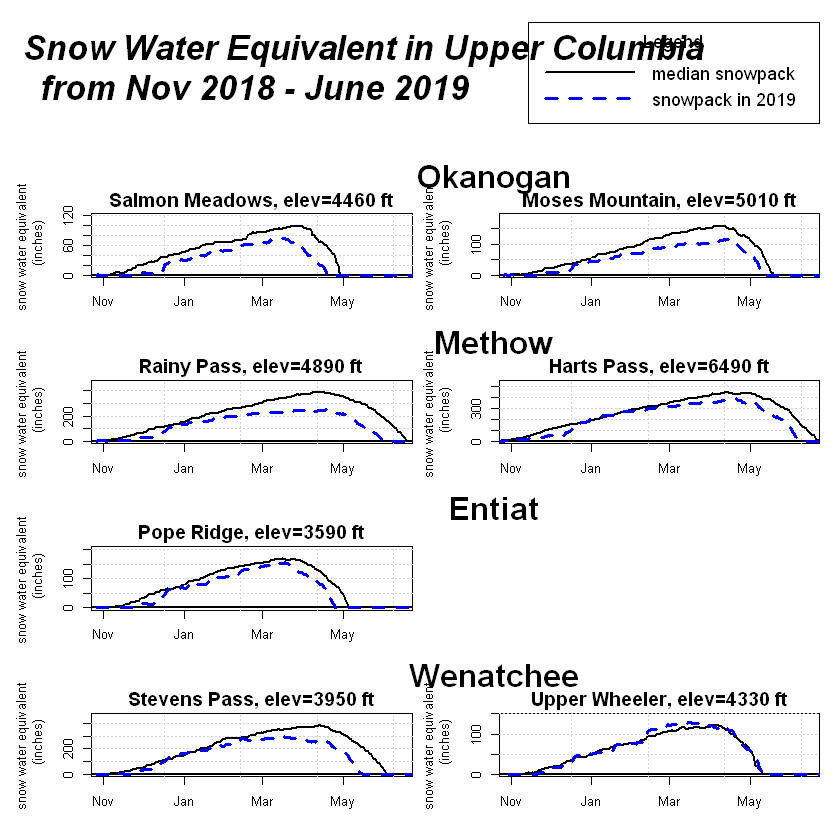

In [132]:
 
# ------------------------------------------------------------
#        (SAME as above - just to print out the plot)
# ------------------------------------------------------------


# options(repr.plot.width=2, repr.plot.height=4)

# Opening the graphical device
#pdf(path_output, width = 7, height = 9)

par(mfrow=c(5, 2), oma=c(0.5, 0.8, 0, 0.8), mar=c(3.5, 5, 3, 0.5),  xpd=FALSE)

for(i in 1:nrow(sites_to_plot)){

    
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( i == 1){
        plot.new()
        par(xpd=TRUE)
        plot.new()
        legend("bottomright", inset=c(0,-0.2), legend=c("median snowpack", paste("snowpack in", year_to_plot, sep=" ") ), 
        lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5), seg.len = 5, cex=1.4)
        
    }
    par(xpd=FALSE)
    
    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(sites_to_plot$site_number[i])
    # ------------------------ generate the median snotel -------------------
    snow_data_x = as.numeric(as.character(all_snotel_data[[as.numeric(sites_to_plot$site_number[i])]]$'snow_water_equivalent_inches' ))
    date_vector = all_snotel_data[[as.numeric(sites_to_plot$site_number[i])]]$'datetime'
    
    # ------------------------ generate the median snotel -------------------
    median_snow_data_x = snotel_generate_median_snow_function(snow_data_x, date_vector, year_to_plot)
    
    # ------------------------------------------------------------
    #         Plot the Data
    # ------------------------------------------------------------
    max_ylim = max(median_snow_data_x$metric, na.rm=T) 
    max_ylim = max_ylim + max_ylim*0.2
    
    xlim_min = as.Date(paste('11-01-',year_to_plot-1, sep=""), format = '%m-%d-%Y')
    xlim_max = as.Date(paste('06-15-',year_to_plot, sep=""), format = '%m-%d-%Y')

    plot(median_snow_data_x$day_of_hydro_year, median_snow_data_x$metric, type='l', col='black', lwd=2,
        xlab=' ',ylab='snow water equivalent \n (inches)', ylim=c(0,max_ylim ), 
        xlim=c(min(median_snow_data_x$day_of_hydro_year) + 30*86400, max(median_snow_data_x$day_of_hydro_year) - 110*86400) )
    grid(lwd=1.5)
    lines(median_snow_data_x$day_of_hydro_year, median_snow_data_x$metric, col='black',lwd=2)
    
    mtext(sites_to_plot$site_name[i], side=3, line=0.3, font=2, cex=0.95)
    
    lines(date_vector, snow_data_x, lwd=2.5, col='blue', lty=2)

    # ------------------------------------------------------------
    #      Insert title
    # ------------------------------------------------------------
    
    if(i == 1){
        
        year_span = paste(year_to_plot-1,year_to_plot,sep=" - June ")
        mtext(paste("                          Snow Water Equivalent in Upper Columbia \n from Nov ",year_span, sep=""), side=3, line=7, cex=1.7, font=4)
        
    }
    
    # ------------------------------------------------------------
    #      Insert legend
    # ------------------------------------------------------------
    
    
    if(i ==2){
        
        #legend("topright", inset=c(0,-0.3), legend=c("median snowpack", paste("snowpack in", year_to_plot, sep=" ") ), 
        #       lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5))
        
    }
    
    # ------------------------------------------------------------
    #      Add Watershed Name
    # ------------------------------------------------------------
    
    if(i == 1){
        mtext('                                                      Okanogan', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 3){
        mtext('                                                      Methow', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 5){
        mtext('                                                      Entiat', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 6){
        mtext('                                                      Wenatchee', side=3, line=1.5, font=2, cex=1.6)
    }
        
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( sites_to_plot$site_number[i]== "699"){
        plot.new()
    }
    
}


# Closing the graphical device
#dev.off() 
